# Creating A Regression Model To Predict Train Delays

# Pre-Processing

## Loading the dataset

In [1]:
import os
import pandas as pd, numpy as np, copy
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import joblib

# Set the option to display all columns, without the "..." in the middle
pd.set_option('display.max_columns', None)

# Directory where the csv data is stored
train_data_dir = 'data/delay data'

def find_csv_filenames(path_to_dir, suffix=".csv"):
    filenames = os.listdir(path_to_dir)
    return [filename for filename in filenames if filename.endswith(suffix)]

def concatenate_csv_files(directory):
    frames = []
    for subdir, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(subdir, file))
                frames.append(df)
    return pd.concat(frames)


train_dataset = concatenate_csv_files(train_data_dir)

# train_dataset.to_csv('./delay_concatenate_train_dataset.csv')

train_dataset_copy = train_dataset.copy()

/var/folders/qx/bgf_wq4d7pxdmbbq4nl3gqg00000gn/T/ipykernel_3284/3543399490.py:23: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(os.path.join(subdir, file))


In [2]:
# List to store column names for different encoding types
columns_for_binary_encoding = []
columns_for_one_hot_encoding = []
columns_for_label_encoding = []
columns_for_target_encoding = []

# Dictionary to store encoding type for each column
encoding_dict = {}

# Iterate over columns in the train_dataset dataframe
for column in train_dataset.columns:
    # Check if the column is of object type
    if train_dataset[column].dtype == 'object':
        # Check the number of unique values in the column
        if len(train_dataset[column].unique()) == 2:
            columns_for_binary_encoding.append(column)
            encoding_dict[column] = 'Binary Encoding'
        elif len(train_dataset[column].unique()) > 2 and len(train_dataset[column].unique()) < 10:
            columns_for_one_hot_encoding.append(column)
            encoding_dict[column] = 'One Hot Encoding'
        elif len(train_dataset[column].unique()) > 11 and len(train_dataset[column].unique()) < 50:
            columns_for_label_encoding.append(column)
            encoding_dict[column] = 'Label Encoding'
        elif len(train_dataset[column].unique()) > 50:
            columns_for_target_encoding.append(column)
            encoding_dict[column] = 'Target Encoding'

# Print the columns for different encoding types
print('Columns for Binary Encoding:', columns_for_binary_encoding)
print('Columns for One Hot Encoding:', columns_for_one_hot_encoding)
print('Columns for Label Encoding:', columns_for_label_encoding)
print('Columns for Target Encoding:', columns_for_target_encoding)
print('\n' + '_' * 20 + '\n')

# Create a DataFrame to display the unique counts and encoding types for each column
unique_counts = pd.DataFrame.from_records(
    [(col, train_dataset[col].dtype, len(train_dataset[col].unique()), encoding_dict.get(col, 'No Encoding')) for col in train_dataset.columns],
    columns=['Column_Name', 'Data_Type', 'Num_Unique_Values', 'Encoding']
)

# Drop columns for binary encoding and unnecessary columns from the train_dataset dataframe
train_dataset.drop(columns=columns_for_binary_encoding, inplace=True)
train_dataset.drop(columns=['pass_wet', 'wta', 'wtd'], inplace=True)

# Print the remaining columns in the train_dataset dataframe
print(train_dataset.columns)


Columns for Binary Encoding: ['arr_atRemoved', 'pass_atRemoved', 'dep_atRemoved']
Columns for One Hot Encoding: ['dep_wet']
Columns for Label Encoding: ['tpl']
Columns for Target Encoding: ['pta', 'ptd', 'wta', 'wtp', 'wtd', 'arr_et', 'arr_wet', 'pass_et', 'dep_et', 'arr_at', 'pass_at', 'dep_at']

____________________

Index(['rid', 'tpl', 'pta', 'ptd', 'wtp', 'arr_et', 'arr_wet', 'pass_et',
       'dep_et', 'dep_wet', 'arr_at', 'pass_at', 'dep_at', 'cr_code',
       'lr_code'],
      dtype='object')


## Creating a departed from LDN column

This code will extract the departing time from london. If no ground truth departing time was recorded, the predicted, planned and estimated times are used instead.

In [3]:
mask = (train_dataset['tpl'] == 'LIVST') & train_dataset['dep_at'].isna()
train_dataset.loc[mask, 'dep_at'] = train_dataset.loc[mask, 'dep_et']

mask = (train_dataset['tpl'] == 'LIVST') & (train_dataset['dep_at'].isna())
train_dataset.loc[mask, 'dep_at'] = train_dataset.loc[mask, 'ptd']

mask = (train_dataset['tpl'] == 'NRCH') & (train_dataset['dep_at'].isna())
train_dataset.loc[mask, 'dep_at'] = train_dataset.loc[mask, 'arr_et']

LDN_departure_times = train_dataset[train_dataset['tpl'] == 'LIVST'][['rid', 'dep_at']].rename(columns={'ptd': 'departure_time'})
NRW_arrival_times = train_dataset[train_dataset['tpl'] == 'NRCH'][['rid', 'arr_at']]

train_dataset = pd.merge(train_dataset, LDN_departure_times, on='rid', how='left')
train_dataset.rename(columns={'dep_at_y' : 'depart_from_LDN'}, inplace=True)

train_dataset

,rid,tpl,pta,ptd,wtp,arr_et,arr_wet,pass_et,dep_et,dep_wet,arr_at,pass_at,dep_at_x,cr_code,lr_code,depart_from_LDN
0,202009016712165,LIVST,NaN,07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06:59,NaN,NaN,06:59
1,202009016712165,BTHNLGR,NaN,NaN,07:03,NaN,NaN,NaN,NaN,NaN,NaN,07:03,NaN,NaN,NaN,06:59
2,202009016712165,BOWJ,NaN,NaN,07:05,NaN,NaN,NaN,NaN,NaN,NaN,07:04,NaN,NaN,NaN,06:59
3,202009016712165,MRYLAND,NaN,NaN,07:06:30,NaN,NaN,NaN,NaN,NaN,NaN,07:06,NaN,NaN,NaN,06:59
4,202009016712165,STFD,NaN,NaN,07:06,NaN,NaN,07:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713985,202204308009724,DISS,01:03,01:05,NaN,NaN,NaN,NaN,NaN,NaN,01:02,NaN,01:04,NaN,NaN,23:29
1713986,202204308009724,TROWSEJ,NaN,NaN,01:19:30,NaN,NaN,NaN,NaN,NaN,NaN,01:18,NaN,NaN,NaN,23:29
1713987,202204308009724,TRWSSBJ,NaN,NaN,01:20,NaN,NaN,01:18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23:29
1713988,202204308009724,NRCHTPJ,NaN,NaN,01:20:30,NaN,NaN,NaN,NaN,NaN,NaN,01:19,NaN,NaN,NaN,23:29


## Extracting the arrival at Norwich station

The time of arrival at Norwich is added to a column to each group of journeys (rid)

In [4]:
# Rename the 'arr_at' column in NRW_arrival_times dataframe to 'arrival_at_norwich'
NRW_arrival_times.rename(columns={'arr_at' : 'arrival_at_norwich'}, inplace=True)

# Merge the train_dataset dataframe with NRW_arrival_times dataframe on the 'rid' column
train_dataset = pd.merge(train_dataset, NRW_arrival_times, on='rid', how='left')

# Display the updated train_dataset dataframe
train_dataset

,rid,tpl,pta,ptd,wtp,arr_et,arr_wet,pass_et,dep_et,dep_wet,arr_at,pass_at,dep_at_x,cr_code,lr_code,depart_from_LDN,arrival_at_norwich
0,202009016712165,LIVST,NaN,07:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06:59,NaN,NaN,06:59,08:52
1,202009016712165,BTHNLGR,NaN,NaN,07:03,NaN,NaN,NaN,NaN,NaN,NaN,07:03,NaN,NaN,NaN,06:59,08:52
2,202009016712165,BOWJ,NaN,NaN,07:05,NaN,NaN,NaN,NaN,NaN,NaN,07:04,NaN,NaN,NaN,06:59,08:52
3,202009016712165,MRYLAND,NaN,NaN,07:06:30,NaN,NaN,NaN,NaN,NaN,NaN,07:06,NaN,NaN,NaN,06:59,08:52
4,202009016712165,STFD,NaN,NaN,07:06,NaN,NaN,07:07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,06:59,08:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713985,202204308009724,DISS,01:03,01:05,NaN,NaN,NaN,NaN,NaN,NaN,01:02,NaN,01:04,NaN,NaN,23:29,01:21
1713986,202204308009724,TROWSEJ,NaN,NaN,01:19:30,NaN,NaN,NaN,NaN,NaN,NaN,01:18,NaN,NaN,NaN,23:29,01:21
1713987,202204308009724,TRWSSBJ,NaN,NaN,01:20,NaN,NaN,01:18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23:29,01:21
1713988,202204308009724,NRCHTPJ,NaN,NaN,01:20:30,NaN,NaN,NaN,NaN,NaN,NaN,01:19,NaN,NaN,NaN,23:29,01:21


In [5]:
train_dataset[['rid','tpl','depart_from_LDN', 'arrival_at_norwich']]

,rid,tpl,depart_from_LDN,arrival_at_norwich
0,202009016712165,LIVST,06:59,08:52
1,202009016712165,BTHNLGR,06:59,08:52
2,202009016712165,BOWJ,06:59,08:52
3,202009016712165,MRYLAND,06:59,08:52
4,202009016712165,STFD,06:59,08:52
...,...,...,...,...
1713985,202204308009724,DISS,23:29,01:21
1713986,202204308009724,TROWSEJ,23:29,01:21
1713987,202204308009724,TRWSSBJ,23:29,01:21
1713988,202204308009724,NRCHTPJ,23:29,01:21


## Converting the string values into date values

In [6]:
# Convert time strings to datetime objects for calculation
train_dataset['depart_from_LDN'] = pd.to_datetime(train_dataset['depart_from_LDN'], format='%H:%M')  # Convert depart_from_LDN column to datetime
train_dataset['dep_at_x'] = pd.to_datetime(train_dataset['dep_at_x'], format='%H:%M')  # Convert dep_at_x column to datetime

train_dataset['pass_at'] = pd.to_datetime(train_dataset['pass_at'], format='%H:%M')  # Convert pass_at column to datetime
train_dataset['pass_et'] = pd.to_datetime(train_dataset['pass_et'], format='%H:%M')  # Convert pass_et column to datetime
train_dataset['arr_at'] = pd.to_datetime(train_dataset['arr_at'], format='%H:%M')  # Convert arr_at column to datetime
train_dataset['dep_et'] = pd.to_datetime(train_dataset['dep_et'], format='%H:%M')  # Convert dep_et column to datetime
train_dataset['arr_wet'] = pd.to_datetime(train_dataset['arr_wet'], format='%H:%M')  # Convert arr_wet column to datetime
train_dataset['ptd'] = pd.to_datetime(train_dataset['ptd'], format='%H:%M')  # Convert ptd column to datetime
train_dataset['pta'] = pd.to_datetime(train_dataset['pta'], format='%H:%M')  # Convert pta column to datetime

# mask = (train_dataset['tpl'] == 'LIVST') & (train_dataset['dep_at_y'].isna())
# train_dataset.loc[mask, 'dep_at_y'] = train_dataset.loc[mask, 'dep_et']
# train_dataset.loc[mask, 'dep_at_x'] = train_dataset.loc[mask, 'dep_et']

In [7]:
train_dataset.head(5)

,rid,tpl,pta,ptd,wtp,arr_et,arr_wet,pass_et,dep_et,dep_wet,arr_at,pass_at,dep_at_x,cr_code,lr_code,depart_from_LDN,arrival_at_norwich
0,202009016712165,LIVST,NaT,1900-01-01 07:00:00,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaT,1900-01-01 06:59:00,NaN,NaN,1900-01-01 06:59:00,08:52
1,202009016712165,BTHNLGR,NaT,NaT,07:03,NaN,NaT,NaT,NaT,NaN,NaT,1900-01-01 07:03:00,NaT,NaN,NaN,1900-01-01 06:59:00,08:52
2,202009016712165,BOWJ,NaT,NaT,07:05,NaN,NaT,NaT,NaT,NaN,NaT,1900-01-01 07:04:00,NaT,NaN,NaN,1900-01-01 06:59:00,08:52
3,202009016712165,MRYLAND,NaT,NaT,07:06:30,NaN,NaT,NaT,NaT,NaN,NaT,1900-01-01 07:06:00,NaT,NaN,NaN,1900-01-01 06:59:00,08:52
4,202009016712165,STFD,NaT,NaT,07:06,NaN,NaT,1900-01-01 07:07:00,NaT,NaN,NaT,NaT,NaT,NaN,NaN,1900-01-01 06:59:00,08:52


In [31]:
train_dataset['temp_dep_at'] = train_dataset['dep_at_x']
train_dataset.loc[train_dataset['temp_dep_at'].isna(),'temp_dep_at'] = train_dataset['pass_at']
train_dataset.loc[train_dataset['temp_dep_at'].isna(),'temp_dep_at'] = train_dataset['wtp']


train_dataset['temp_arr_at'] = train_dataset['arr_at']

In [18]:
train_dataset[['pta','arr_at', 'ptd','dep_at_x']]

,pta,arr_at,ptd,dep_at_x
0,NaT,NaT,1900-01-01 07:00:00,1900-01-01 06:59:00
1,NaT,NaT,NaT,NaT
2,NaT,NaT,NaT,NaT
3,NaT,NaT,NaT,NaT
4,NaT,NaT,NaT,NaT
...,...,...,...,...
1713985,1900-01-01 01:03:00,1900-01-01 01:02:00,1900-01-01 01:05:00,1900-01-01 01:04:00
1713986,NaT,NaT,NaT,NaT
1713987,NaT,NaT,NaT,NaT
1713988,NaT,NaT,NaT,NaT


In [13]:
(train_dataset['pta'] - train_dataset['arr_at']).dropna()

19        0 days 00:02:00
20        0 days 00:02:00
22        0 days 00:03:00
25        0 days 00:02:00
27        0 days 00:02:00
                ...      
1713978   0 days 00:01:00
1713980   0 days 00:02:00
1713983   0 days 00:01:00
1713985   0 days 00:01:00
1713989   0 days 00:01:00
Length: 328416, dtype: timedelta64[ns]

In [15]:
(train_dataset['ptd'] - train_dataset['dep_at_x']).dropna()

0         0 days 00:01:00
15        0 days 00:01:00
19        0 days 00:01:00
20        0 days 00:00:00
22        0 days 00:01:00
                ...      
1713977   0 days 00:01:00
1713978   0 days 00:00:00
1713980   0 days 00:01:00
1713983   0 days 00:01:00
1713985   0 days 00:01:00
Length: 354894, dtype: timedelta64[ns]

In [10]:
train_dataset.dtypes

rid                            int64
tpl                           object
pta                   datetime64[ns]
ptd                   datetime64[ns]
wtp                           object
arr_et                        object
arr_wet               datetime64[ns]
pass_et               datetime64[ns]
dep_et                datetime64[ns]
dep_wet                       object
arr_at                datetime64[ns]
pass_at               datetime64[ns]
dep_at_x              datetime64[ns]
cr_code                      float64
lr_code                      float64
depart_from_LDN       datetime64[ns]
arrival_at_norwich            object
dtype: object

## Extracting the departing time from each individual station

Similar to extracting the a the departing time for London. A sequential extraction of each stations departing time is made, if no ground truth values were recorded, the predicted, estiamted and planned values are used.

In [40]:
train_dataset['depart_from_current_station'] = train_dataset['dep_at_x']
train_dataset['depart_from_current_station'] = train_dataset['depart_from_current_station'].fillna(train_dataset['dep_et'])
train_dataset['depart_from_current_station'] = train_dataset['depart_from_current_station'].fillna(train_dataset['ptd'])
train_dataset['depart_from_current_station'] = train_dataset['depart_from_current_station'].fillna(train_dataset['wtp'])
train_dataset['depart_from_current_station'] = train_dataset['depart_from_current_station'].fillna(train_dataset['pass_at'])
train_dataset['depart_from_current_station'] = train_dataset['depart_from_current_station'].fillna(train_dataset['dep_et'])
train_dataset['depart_from_current_station'] = train_dataset['depart_from_current_station'].fillna(train_dataset['pta'])
train_dataset['depart_from_current_station'] = train_dataset['depart_from_current_station'].fillna(train_dataset['arr_wet'])
train_dataset['depart_from_current_station'] = train_dataset['depart_from_current_station'].fillna(train_dataset['arr_at'])


# train_dataset['arrive_at_NRW'] = train_dataset.loc[train_dataset['rid']]

# train_dataset['time_passed'] = train_dataset['time_passed'].fillna(train_dataset.loc[train_dataset['tpl']== 'NRCH', 'arr_at'] - train_dataset['dep_at_y'])

In [41]:
train_dataset.head(5)

,rid,tpl,pta,ptd,wtp,arr_et,arr_wet,pass_et,dep_et,dep_wet,arr_at,pass_at,dep_at_x,cr_code,lr_code,depart_from_LDN,arrival_at_norwich,depart_from_current_station
0,202009016712165,LIVST,NaT,1900-01-01 07:00:00,NaN,NaN,NaT,NaT,NaT,NaN,NaT,NaT,1900-01-01 06:59:00,NaN,NaN,1900-01-01 06:59:00,08:52,1900-01-01 06:59:00
1,202009016712165,BTHNLGR,NaT,NaT,07:03,NaN,NaT,NaT,NaT,NaN,NaT,1900-01-01 07:03:00,NaT,NaN,NaN,1900-01-01 06:59:00,08:52,2024-05-13 07:03:00
2,202009016712165,BOWJ,NaT,NaT,07:05,NaN,NaT,NaT,NaT,NaN,NaT,1900-01-01 07:04:00,NaT,NaN,NaN,1900-01-01 06:59:00,08:52,2024-05-13 07:05:00
3,202009016712165,MRYLAND,NaT,NaT,07:06:30,NaN,NaT,NaT,NaT,NaN,NaT,1900-01-01 07:06:00,NaT,NaN,NaN,1900-01-01 06:59:00,08:52,2024-05-13 07:06:30
4,202009016712165,STFD,NaT,NaT,07:06,NaN,NaT,1900-01-01 07:07:00,NaT,NaN,NaT,NaT,NaT,NaN,NaN,1900-01-01 06:59:00,08:52,2024-05-13 07:06:00


## Creating functions to convert the time value to numeric value and reverse the numeric value back to time value

In [42]:
# Function to convert a time string to seconds
def convert_string_to_seconds(time_str):
    """
    Converts a time string to the total number of seconds.
    
    Parameters:
    time_str (str): The time string to be converted. It should be in the format 'HH:MM:SS' or 'HH:MM'.
    
    Returns:
    int: The total number of seconds represented by the time string.
    """
    try:
        # Try to convert the time string to datetime format with seconds
        date_time_value = pd.to_datetime(time_str, format='%H:%M:%S')
        total_seconds = date_time_value.hour * 3600 + date_time_value.minute * 60 + date_time_value.second
    
    except:
        # If the conversion fails, try to convert the time string to datetime format without seconds
        date_time_value = pd.to_datetime(time_str, format='%H:%M')
        total_seconds = date_time_value.hour * 3600 + date_time_value.minute * 60 + date_time_value.second
        
    return total_seconds

# Function to convert seconds to a time string
def convert_seconds_to_string(seconds):
    """
    Converts the given number of seconds into a string representation of time in the format HH:MM:SS.

    Parameters:
    seconds (int): The number of seconds to convert.

    Returns:
    str: The string representation of time in the format HH:MM:SS.
    """
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return "{:02d}:{:02d}:{:02d}".format(int(hours), int(minutes), int(seconds))

def convert_string_to_seconds_vectorized(time_series):
    """
    Converts a time series represented as strings in the format 'HH:MM:SS' or 'HH:MM' to a vector of total seconds.

    Parameters:
    time_series (pandas.Series): A pandas Series containing time series data in string format.

    Returns:
    pandas.Series: A pandas Series containing the total seconds for each time value in the input time series.

    Example:
    >>> time_series = pd.Series(['12:34:56', '01:23:45', '10:00'])
    >>> convert_string_to_seconds_vectorized(time_series)
    0    45296
    1     5025
    2    36000
    dtype: int64
    """
    
    time_series_dt = pd.to_datetime(time_series, format='%H:%M:%S', errors='coerce')
    time_series_dt[time_series_dt.isna()] = pd.to_datetime(time_series[time_series_dt.isna()], format='%H:%M')
    total_seconds = time_series_dt.dt.hour * 3600 + time_series_dt.dt.minute * 60 + time_series_dt.dt.second
    return total_seconds

## Defining the features that will be used

In [43]:
features = ['rid','tpl','depart_from_LDN', 'depart_from_current_station', 'arrival_at_norwich']

In [44]:
train_dataset[features].head(5)

,rid,tpl,depart_from_LDN,depart_from_current_station,arrival_at_norwich
0,202009016712165,LIVST,1900-01-01 06:59:00,1900-01-01 06:59:00,08:52
1,202009016712165,BTHNLGR,1900-01-01 06:59:00,2024-05-13 07:03:00,08:52
2,202009016712165,BOWJ,1900-01-01 06:59:00,2024-05-13 07:05:00,08:52
3,202009016712165,MRYLAND,1900-01-01 06:59:00,2024-05-13 07:06:30,08:52
4,202009016712165,STFD,1900-01-01 06:59:00,2024-05-13 07:06:00,08:52


## Converting the feature column vales to numeric values

In [45]:
# Iterate over each feature in the 'features' list starting from the third feature
for feature in features[2:]:
    pass
    # Convert the string values in the specified feature column to seconds using the 'convert_string_to_seconds_vectorized' function
    train_dataset[feature] = convert_string_to_seconds_vectorized(train_dataset[feature])

In [46]:
train_dataset[features].head(5)

,rid,tpl,depart_from_LDN,depart_from_current_station,arrival_at_norwich
0,202009016712165,LIVST,25140.0,25140,31920.0
1,202009016712165,BTHNLGR,25140.0,25380,31920.0
2,202009016712165,BOWJ,25140.0,25500,31920.0
3,202009016712165,MRYLAND,25140.0,25590,31920.0
4,202009016712165,STFD,25140.0,25560,31920.0


## Encoding the train station code using Label Encoder

In [47]:
from sklearn.preprocessing import LabelEncoder

# create the LabelEncoder object
le = LabelEncoder()

# fit the encoder
le.fit(train_dataset['tpl'])

joblib.dump(le, 'train_station_encoder_model.sav', compress=3)

# to de-code values use decoded_values = loaded_model.inverse_transform(encoded_values)


# create a DataFrame with the original and encoded values
encoding_table = pd.DataFrame({
    'Original Value': le.classes_,
    'Encoded Value': range(len(le.classes_))
})

print(encoding_table)

train_dataset['tpl'] = le.fit_transform(train_dataset['tpl'])

   Original Value  Encoded Value
0            BOWJ              0
1         BROXBRN              1
2         BRTWOOD              2
3         BTHNLGR              3
4         CHDWLHT              4
5         CHESHNT              5
6         CHLMSFD              6
7         CLCHSTR              7
8            DISS              8
9          FRSTGT              9
10        FRSTGTJ             10
11        GIDEAPK             11
12        GIDEPKJ             12
13        GODMAYS             13
14        HAGHLYJ             14
15        HAKNYNM             15
16        HFLPEVL             16
17        HRLDWOD             17
18        ILFELEJ             18
19         ILFORD             19
20        INGTSTL             20
21        INGTSTN             21
22        IPSWEPJ             22
23        IPSWESJ             23
24        IPSWHJN             24
25        IPSWICH             25
26        KELVEDN             26
27          LIVST             27
28        MANNGTR             28
29        

In [48]:
import pandas as pd

def get_shapes_of_journeys(df):
    """
    Calculate and return the shapes and counts of groups in a DataFrame.

    Parameters:
    df (pandas.DataFrame): The input DataFrame containing the data.

    Returns:
    pandas.DataFrame: A DataFrame containing the shapes and counts.
    """

    # Group by 'rid', calculate the shape of each group, and count the occurrences of each shape
    shape_counts = df.groupby('rid').apply(lambda x: x.shape).value_counts()

    # Sort the Series by the first element of the shape tuple
    sorted_shape_counts = shape_counts.sort_index(key=lambda x: x.map(lambda y: y[0]))

    # Create a DataFrame from the sorted shape counts
    df_shape_counts = pd.DataFrame(sorted_shape_counts.items(), columns=['Shape', 'Count'])

    return df_shape_counts

get_shapes_of_journeys(train_dataset)

/var/folders/qx/bgf_wq4d7pxdmbbq4nl3gqg00000gn/T/ipykernel_7374/3156949966.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shape_counts = df.groupby('rid').apply(lambda x: x.shape).value_counts()


,Shape,Count
0,"(1, 18)",1
1,"(2, 18)",20
2,"(3, 18)",61
3,"(4, 18)",36
4,"(5, 18)",10
5,"(6, 18)",504
6,"(7, 18)",357
7,"(8, 18)",121
8,"(9, 18)",428
9,"(10, 18)",40


## Splitting the dataset into training and validation

In [49]:
print(f"Number of missing y values: {len(train_dataset.loc[train_dataset['arrival_at_norwich'].isna()])}\n")

train_dataset.dropna(subset=['arrival_at_norwich'],inplace=True) # There are a few Nan values in the y column. For now we're just dropping them 
# TODO: Fix the missing values of y 

print(f"Number of missing y values after dropping them: {len(train_dataset.loc[train_dataset['arrival_at_norwich'].isna()])}\n")

train_dataset.loc[train_dataset['arrival_at_norwich'].isna()]

Number of missing y values: 53856

Number of missing y values after dropping them: 0



,rid,tpl,pta,ptd,wtp,arr_et,arr_wet,pass_et,dep_et,dep_wet,arr_at,pass_at,dep_at_x,cr_code,lr_code,depart_from_LDN,arrival_at_norwich,depart_from_current_station


In [50]:
from sklearn.model_selection import GroupShuffleSplit

# Define the proportion of data to allocate to the validation set (e.g., 20%)
validation_proportion = 0.2

# Create an instance of GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, test_size=validation_proportion, random_state=42)

# Get the indices for the training and validation sets
train_idx, val_idx = next(gss.split(train_dataset, groups=train_dataset['rid']))

# Create the training and validation sets
train_set = train_dataset.iloc[train_idx]
validation_set = train_dataset.iloc[val_idx]


X_train = train_set[features[1:-1]]
y_train = train_set[features[-1]]

X_val = validation_set[features[1:-1]]
y_val = validation_set[features[-1]]

X_train.head(5)

y_train.head(5)

0    31920.0
1    31920.0
2    31920.0
3    31920.0
4    31920.0
Name: arrival_at_norwich, dtype: float64

In [51]:
print(get_shapes_of_journeys(train_set))
print(get_shapes_of_journeys(validation_set))

/var/folders/qx/bgf_wq4d7pxdmbbq4nl3gqg00000gn/T/ipykernel_7374/3156949966.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shape_counts = df.groupby('rid').apply(lambda x: x.shape).value_counts()


       Shape  Count
0    (2, 18)      3
1    (3, 18)      4
2    (4, 18)      6
3    (5, 18)      5
4    (6, 18)      9
5    (7, 18)     12
6    (8, 18)      2
7    (9, 18)     21
8   (10, 18)      5
9   (11, 18)      8
10  (12, 18)      6
11  (13, 18)     19
12  (14, 18)    137
13  (15, 18)     41
14  (16, 18)    108
15  (17, 18)      8
16  (18, 18)      9
17  (19, 18)      4
18  (22, 18)      6
19  (23, 18)     16
20  (24, 18)      3
21  (25, 18)    128
22  (26, 18)     30
23  (27, 18)      2
24  (28, 18)     77
25  (29, 18)    115
26  (30, 18)    289
27  (31, 18)   7560
28  (32, 18)  33300
29  (33, 18)     43
30  (34, 18)      4
31  (35, 18)     68
       Shape  Count
0    (2, 18)      1
1    (3, 18)      1
2    (4, 18)      1
3    (5, 18)      2
4    (6, 18)      3
5    (7, 18)      5
6    (8, 18)      1
7    (9, 18)      8
8   (10, 18)      1
9   (11, 18)      2
10  (12, 18)      3
11  (13, 18)      5
12  (14, 18)     28
13  (15, 18)     12
14  (16, 18)     26
15  (18, 18)      2


/var/folders/qx/bgf_wq4d7pxdmbbq4nl3gqg00000gn/T/ipykernel_7374/3156949966.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shape_counts = df.groupby('rid').apply(lambda x: x.shape).value_counts()


/var/folders/qx/bgf_wq4d7pxdmbbq4nl3gqg00000gn/T/ipykernel_7374/3156949966.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shape_counts = df.groupby('rid').apply(lambda x: x.shape).value_counts()
/var/folders/qx/bgf_wq4d7pxdmbbq4nl3gqg00000gn/T/ipykernel_7374/3156949966.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  shape_counts = df.groupby('rid').apply(lambda x: x.shape).value_counts()


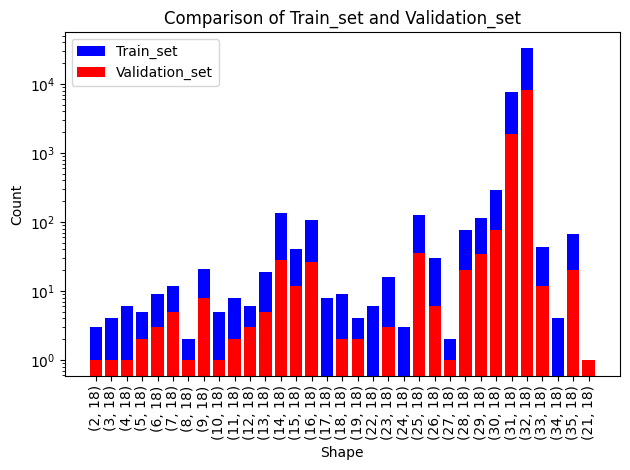

In [52]:
import matplotlib.pyplot as plt

def plot_df(df1, df2, title1, title2):
    """
    Plots a comparison of two DataFrames.

    Args:
        df1 (DataFrame): The first DataFrame to plot.
        df2 (DataFrame): The second DataFrame to plot.
        title1 (str): The title for the first DataFrame.
        title2 (str): The title for the second DataFrame.

    Returns:
        None
    """
    # Create a new figure
    fig, ax = plt.subplots()

    # Plot the 'Count' column from the first DataFrame
    ax.bar(df1['Shape'].astype(str), df1['Count'], color='b', label=title1)

    # Plot the 'Count' column from the second DataFrame
    ax.bar(df2['Shape'].astype(str), df2['Count'], color='r', label=title2)

    ax.set_title('Comparison of ' + title1 + ' and ' + title2)
    ax.set_xlabel('Shape')
    ax.set_ylabel('Count')
    ax.set_yscale('log')  # Set y-axis to logarithmic scale
    plt.xticks(rotation=90)  # Rotate x-axis labels 90 degrees

    # Add a legend
    ax.legend()

    # Automatically adjust subplot parameters to give specified padding
    fig.tight_layout()

    # Show the plot
    plt.show()

plot_df(get_shapes_of_journeys(train_set), get_shapes_of_journeys(validation_set), 'Train_set', 'Validation_set')

# Metrics

# Building Models

The commonly used metrics for scoring the performance of regression models are:

- Mean Squared Error (MSE).

- Root Mean Squared Error (RMSE).

- Mean Absolute Error (MAE).

- R2 Score.

## Mean Squared Error (MSE)

$MSE = \frac{1}{n} \sum_{i=1}^{n} (Y_i - \hat{Y_i})^2$

In [53]:
from sklearn.metrics import mean_squared_error

def mse_score(y, predictions):
    """
    Calculates the mean squared error (MSE) between the true values (y) and the predicted values.

    Parameters:
    y (array-like): The true values.
    predictions (array-like): The predicted values.

    Returns:
    float: The mean squared error (MSE) score.
    """
    mse = mean_squared_error(y, predictions)
    return mse

## Root Mean Squared Error (RMSE)

If we are concerned about large errors, RMSE is a good metric to use

\
$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$


\
<small>*Ogunbiyi, I. A. (2022). Top Evaluation Metrics for Regression Problems in Machine Learning. FreeCodeCamp. Retrieved from https://www.freecodecamp.org/news/evaluation-metrics-for-regression-problems-machine-learning*<small>

In [54]:
from sklearn.metrics import mean_squared_error

def rmse_score(y, predictions):
    """
    Calculate the Root Mean Squared Error (RMSE) between the true values (y) and the predicted values.

    Parameters:
    y (array-like): The true values.
    predictions (array-like): The predicted values.

    Returns:
    float: The RMSE score.

    """
    rmse_score = np.sqrt(mean_squared_error(y, predictions))
    return rmse_score


## Mean Absolute Error (MAE)

$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$

\
The model’s average absolute distance when making a prediction

\
<small>*Ogunbiyi, I. A. (2022). Top Evaluation Metrics for Regression Problems in Machine Learning. FreeCodeCamp. Retrieved from https://www.freecodecamp.org/news/evaluation-metrics-for-regression-problems-machine-learning*<small>

In [55]:
from sklearn.metrics import mean_absolute_error

def score_mae(y, predictions):
    """
    Calculate the Mean Absolute Error (MAE) score between the true values (y) and the predicted values.

    Parameters:
    y (array-like): The true values.
    predictions (array-like): The predicted values.

    Returns:
    float: The MAE score.
    """
    mae_score = mean_absolute_error(y, predictions)
    return mae_score


## R2 Score

$R^2 = 1 - \frac{RSS}{TSS}$ | The coefficient of determination

$RSS = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$ | The sum of squares of residuals

$TSS = \sum_{i=1}^{n} (y_i - \bar{y})^2$ | Total sum of squares


\
<small>*Ogunbiyi, I. A. (2022). Top Evaluation Metrics for Regression Problems in Machine Learning. FreeCodeCamp. Retrieved from https://www.freecodecamp.org/news/evaluation-metrics-for-regression-problems-machine-learning*<small>

In [56]:
from sklearn.metrics import r2_score

def score_r2(y, predictions):
    """
    Calculate the R2 score between the predicted values and the actual values.

    Parameters:
    y (array-like): The actual target values.
    predictions (array-like): The predicted values.

    Returns:
    float: The R2 score between the predicted values and the actual values.
    """
    r2score = r2_score(y, predictions)
    
    return r2score

# Models

In [57]:
from joblib import dump, load


models= []

## 1) MLPRegressor

In [58]:
from sklearn.neural_network import MLPRegressor

# mlp = MLPRegressor(hidden_layer_sizes=150,solver='sgd', max_iter=50, activation='logistic',random_state=0, learning_rate_init=0.001,verbose = 1, momentum=0.9, tol=0.001, early_stopping=True)

# Define the model
mlp = MLPRegressor(verbose = 1, early_stopping=True, random_state=42)

# Train the model
mlp.fit(X_train, y_train)

models.append(mlp)

# # Make predictions
# mlp_pred = mlp.predict(X_val)

# # Calculate the score of the predictions
# mlp_mse_score = mean_squared_error(y_val, mlp_pred)

# # Calculate RMSE
# mlp_rmse_score = sqrt(mlp_mse_score)

# print('Unfiltered Scores: ')
# print(f"Prediction MSE score: {mlp_mse_score}")
# print(f"Prediction RMSE score: {mlp_rmse_score}")
# print(f"Prediction RMSE score in seconds: {convert_seconds_to_string(mlp_rmse_score)}")

Iteration 1, loss = 152091418.81394377
Validation score: 0.307134
Iteration 2, loss = 144407618.21715006
Validation score: 0.311864
Iteration 3, loss = 143373378.83923426
Validation score: 0.313951
Iteration 4, loss = 142687074.18113124
Validation score: 0.317665
Iteration 5, loss = 142327880.63660181
Validation score: 0.319965
Iteration 6, loss = 142064492.01561481
Validation score: 0.322001
Iteration 7, loss = 141945125.12690508
Validation score: 0.320883
Iteration 8, loss = 141602117.54708177
Validation score: 0.321483
Iteration 9, loss = 141287633.97649527
Validation score: 0.324049
Iteration 10, loss = 140978119.07101578
Validation score: 0.317304
Iteration 11, loss = 140830783.04370466
Validation score: 0.322714
Iteration 12, loss = 140528068.42375326
Validation score: 0.328887
Iteration 13, loss = 140329422.54375216
Validation score: 0.324023
Iteration 14, loss = 140102868.42109421
Validation score: 0.329739
Iteration 15, loss = 139943703.37615043
Validation score: 0.331630
Iter

## 2) MLP Sequential

In [59]:

# from keras.models import Sequential
# from keras.layers import Dense
# from keras.callbacks import EarlyStopping

# # Define the model
# model = Sequential()
# model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
# model.add(Dense(16, activation='relu'))
# model.add(Dense(1, activation='linear'))

# # Compile the model
# model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error', 'mean_squared_error'])
# # Define the early stopping criteria
# early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, callbacks=[early_stopping])
# # Evaluate the model
# loss = model.evaluate(X_val, y_val)
# print('Test loss:', loss)


# mlp_results = pd.DataFrame()

# mlp_results['true'] = y_val
# mlp_results['mlp_pred'] = model.predict(X_val)
# X_val
# # Define the data for each column
# data = {
#     'tpl': [19],
#     'depart_from_LDN': [62400],
#     'depart_from_current_station': [62400 + 2000]
# }

# # Create the DataFrame
# mock_data = pd.DataFrame(data, columns=features)

# mock_data.drop(columns=['arrival_at_norwich','rid'],inplace=True)

# mock_data
# model.predict(mock_data)
# mlp_results

## 3) KN regression

In [60]:
from sklearn.neighbors import KNeighborsRegressor
import warnings

#ignore the Pd concat decrepit warning
warnings.simplefilter(action='ignore', category=FutureWarning)

min_score = float('inf')
knn_results = pd.DataFrame(columns=['k', 'R^2', 'MAE', 'MSE', 'RMSE'])

# Initialize k to 1
k = 1

# Loop while k is less than or equal to 100
while k <= 100:
    # Print the current value of k
    print(k)
        
    # Create a KNeighborsRegressor with k neighbors and fit it to the training data
    knn_regressor = KNeighborsRegressor(n_neighbors=k, n_jobs=-1)
    knn_regressor.fit(X_train, y_train)
    
    # Predict the validation data
    y_pred = knn_regressor.predict(X_val)
    
    # Calculate the mean absolute error, mean squared error, and root mean squared error
    knn_mae = mean_absolute_error(y_val, y_pred)
    knn_mse = mean_squared_error(y_val, y_pred)
    knn_rmse = np.sqrt(knn_mse)  # Take the square root of the MSE to get the RMSE
    
    if knn_rmse <= min_score:  # Check if the current RMSE is at least 5% less than the minimum
        min_score = knn_rmse
    else:
        print('\nModel is not improving, stopping here\n')
        break
        
    print(f'Score for k={k}:')
    print(f'R^2: {knn_regressor.score(X_val, y_val)}')
    print(f'MAE: {knn_mae}')
    print(f'MSE: {knn_mse}')
    print(f'RMSE: {knn_rmse}')
    # print(f'RMSE (in time): {convert_string_to_seconds(rmse)}')
    print('-------------------------')
    
    new_row = pd.DataFrame({'k': [k], 'R^2': [knn_regressor.score(X_val, y_val)], 'MAE': [knn_mae], 'MSE': [knn_mse], 'RMSE': [knn_rmse]})
    knn_results = pd.concat([knn_results, new_row], ignore_index=True)
    
        
    # Increment k based on its current value
    if k < 10:
        k += 1  # Increment by 1 if k is less than 10
    elif k <= 50:
        k += 5  # Increment by 5 if k is less than or equal to 50
    else:
        k += 10  # Increment by 10 otherwise

# knn_predictions = knn_regressor.predict(X_val)
models.append(knn_regressor)
print(knn_results)

# dump(knn_regressor, '/models/knn_regressor.joblib', compress= True) 

# knn_regressor = load('/models/knn_regressor.joblib')


1


Score for k=1:
R^2: 0.9808587748996705
MAE: 430.9835226074645
MSE: 8042961.477241919
RMSE: 2836.011543919016
-------------------------
2
Score for k=2:
R^2: 0.9896857098150489
MAE: 378.64587161490493
MSE: 4333967.0364792
RMSE: 2081.818204473964
-------------------------
3
Score for k=3:
R^2: 0.9899056464431203
MAE: 379.5673705455312
MSE: 4241551.748651987
RMSE: 2059.5027916106324
-------------------------
4
Score for k=4:
R^2: 0.9899693365293835
MAE: 390.94327800704883
MSE: 4214789.777690755
RMSE: 2052.9953184775545
-------------------------
5
Score for k=5:
R^2: 0.9910095880255597
MAE: 378.8687772991535
MSE: 3777685.952489683
RMSE: 1943.6270096110732
-------------------------
6
Score for k=6:
R^2: 0.991376919732231
MAE: 378.1208844172666
MSE: 3623336.6487935656
RMSE: 1903.5064089184375
-------------------------
7
Score for k=7:
R^2: 0.9918127549453005
MAE: 369.97613381587837
MSE: 3440202.8205892695
RMSE: 1854.7783750597455
-------------------------
8
Score for k=8:
R^2: 0.991921593171

In [61]:
print(knn_results)

     k       R^2         MAE           MSE         RMSE
0    1  0.980859  430.983523  8.042961e+06  2836.011544
1    2  0.989686  378.645872  4.333967e+06  2081.818204
2    3  0.989906  379.567371  4.241552e+06  2059.502792
3    4  0.989969  390.943278  4.214790e+06  2052.995318
4    5  0.991010  378.868777  3.777686e+06  1943.627010
5    6  0.991377  378.120884  3.623337e+06  1903.506409
6    7  0.991813  369.976134  3.440203e+06  1854.778375
7    8  0.991922  369.186207  3.394470e+06  1842.408757
8    9  0.992090  367.735659  3.323583e+06  1823.069533
9   10  0.992243  365.297449  3.259441e+06  1805.392140
10  15  0.992582  358.233599  3.117158e+06  1765.547432
11  20  0.992764  350.283342  3.040304e+06  1743.646736
12  25  0.992883  343.355327  2.990560e+06  1729.323541
13  30  0.992947  338.627936  2.963490e+06  1721.479148
14  35  0.992962  336.088712  2.957100e+06  1719.622033
15  40  0.992983  333.647973  2.948614e+06  1717.152917
16  45  0.992983  333.951899  2.948512e+06  1717

### Plotting the scores against value of K

In [62]:
def plot_KNN_Stats(stats):
    for metric in stats:
        plt.figure(figsize=(10, 6))
        plt.plot(stats['k'], stats[metric], marker='o')
        plt.title(f'KNN Regression model {metric} vs k')
        plt.xlabel('k')
        plt.ylabel(metric)
        plt.grid(True)
        plt.savefig(f'plots/KNN_Regression/KNN Regression model {metric} vs k.pdf')
        plt.savefig(f'plots/KNN_Regression/KNN Regression model {metric} vs k.jpeg')
        plt.close()
        
plot_KNN_Stats(knn_results)

## 4) XGBoost Regression

In [63]:
import xgboost as xg 

# Initialize a DataFrame to store the results
xgboost_reg_results = pd.DataFrame(columns=['n_estimators', 'RMSE', 'MAE', 'R2'])

min_score = float('inf')

n_est=1

while n_est < 100:
# for n_est in range(1,100):
    # Instantiation 
    xgb_r = xg.XGBRegressor(objective ='reg:squarederror', n_estimators = n_est, seed = 123, n_jobs=-1) 
    
    # Fitting the model 
    xgb_r.fit(X_train, y_train) 
    
    # Predict the model 
    xgboost_reg_pred = xgb_r.predict(X_val) 
    
    # RMSE Computation 
    xgboost_reg_rmse = np.sqrt(mean_squared_error(y_val, xgboost_reg_pred)) 

    # MAE Computation
    xgboost_reg_mae = mean_absolute_error(y_val, xgboost_reg_pred)

    # R^2 Score Computation
    xgboost_reg_r2 = r2_score(y_val, xgboost_reg_pred)

    # MSLE Computation
    # msle = mean_squared_log_error(y_val, pred) <-- removed as throws an error eventually

    print(f'\nn_estimators: {n_est}')
    print("RMSE : % f" %(xgboost_reg_rmse))
    print("MAE : % f" %(xgboost_reg_mae))
    print("R^2 Score : % f" %(xgboost_reg_r2))
    # print("MSLE : % f" %(msle))
    print('-' * 30)
    
    # Append the results to the DataFrame
    xgboost_reg_results = pd.concat(
        [xgboost_reg_results, 
         pd.DataFrame([{'n_estimators': n_est, 'RMSE': xgboost_reg_rmse, 'MAE': xgboost_reg_mae, 'R2': xgboost_reg_r2}])], ignore_index=True)

    if knn_rmse <= min_score:  # Check if the current RMSE is at least 5% less than the minimum
        min_score = knn_rmse
    else:
        print('\nModel is not improving by at least 5%, stopping here\n')
        break


    if n_est < 10:
        n_est += 1
    elif n_est <= 50:
        n_est += 5
    elif n_est <= 100:
        n_est += 10
    
    
    #     # Increment k based on its current value
    # if k < 10:
    #     k += 1  # Increment by 1 if k is less than 10
    # elif k <= 50:
    #     k += 5  # Increment by 5 if k is less than or equal to 50
    # else:
    #     k += 10  # Increment by 10 otherwise
    
models.append(xgb_r)

# Display the DataFrame

print(xgboost_reg_results)
# xgb_r.save_model('/Users/joshuanewton/Desktop/temp/xgboost_model.json')


n_estimators: 1
RMSE :  14423.881550
MAE :  11689.875945
R^2 Score :  0.504871
------------------------------

n_estimators: 2
RMSE :  10194.480707
MAE :  8214.249700
R^2 Score :  0.752666
------------------------------

n_estimators: 3
RMSE :  7270.192730
MAE :  5782.620130
R^2 Score :  0.874210
------------------------------

n_estimators: 4
RMSE :  5271.073107
MAE :  4084.681260
R^2 Score :  0.933877
------------------------------

n_estimators: 5
RMSE :  3932.805430
MAE :  2900.675047
R^2 Score :  0.963191
------------------------------

n_estimators: 6
RMSE :  3064.765834
MAE :  2075.270793
R^2 Score :  0.977646
------------------------------

n_estimators: 7
RMSE :  2530.248765
MAE :  1506.208446
R^2 Score :  0.984764
------------------------------

n_estimators: 8
RMSE :  2219.225104
MAE :  1115.703541
R^2 Score :  0.988279
------------------------------

n_estimators: 9
RMSE :  2047.260012
MAE :  852.227672
R^2 Score :  0.990025
------------------------------

n_estimators: 10

### Plotting scores against number of estimators

In [64]:
def plot_XGB_Stats(stats):
    for metric in stats:
        plt.figure(figsize=(10, 6))
        plt.plot(stats['n_estimators'], stats[metric], marker='o')
        plt.title(f'XGBoost Regression model {metric} vs number of estimators')
        plt.xlabel('n_estimators')
        plt.ylabel(metric)
        plt.grid()
        plt.savefig(f'plots/XGB/XGBoost Regression model {metric} vs n_estimators.jpeg')
        plt.savefig(f'plots/XGB/XGBoost Regression model {metric} vs n_estimators.pdf')
        plt.close()

plot_XGB_Stats(xgboost_reg_results)

## 9) RandomForestRegressor

In [65]:
from sklearn.ensemble import RandomForestRegressor

# Initialize a DataFrame to store the results
rf_results = pd.DataFrame(columns=['n_estimators', 'RMSE', 'MAE', 'R2'])

k=5

while k <=100:
    # Create a RandomForestRegressor object
    rf = RandomForestRegressor(n_estimators=k, random_state=0, n_jobs=-1, verbose=0)

    # Train the model using the training sets
    rf.fit(X_train, y_train)
    
    # dump(rf, f'/Users/joshuanewton/Desktop/temp/random_forest_{k}_trees.joblib', compress= True) 
    
    # Predict the model 
    rf_pred = rf.predict(X_val) 
    
    # RMSE Computation 
    rf_rmse = np.sqrt(mean_squared_error(y_val, rf_pred)) 

    # MAE Computation
    rf_mae = mean_absolute_error(y_val, rf_pred)

    # R^2 Score Computation
    rf_r2 = r2_score(y_val, rf_pred)

    print(f'\nn_estimators: {k}')
    print("RMSE : % f" %(rf_rmse))
    print("MAE : % f" %(rf_mae))
    print("R^2 Score : % f" %(rf_r2))
    print('-' * 30)
    
    # Append the results to the DataFrame
    rf_results = pd.concat(
        [rf_results, 
         pd.DataFrame([{'n_estimators': k, 'RMSE': rf_rmse, 'MAE': rf_mae, 'R2': rf_r2}])], ignore_index=True)
    
    
    if k>= 10:
        k += 5
    elif k >= 50:
        k += 10
    elif k >= 80:
        k=100
    else:
        k +=1
 
 
rf = RandomForestRegressor(n_estimators=8, random_state=0, n_jobs=-1, verbose=0)
rf.fit(X_train, y_train)    

models.append(rf)
print(rf_results)


n_estimators: 5
RMSE :  1692.184531
MAE :  322.930468
R^2 Score :  0.993185
------------------------------

n_estimators: 6
RMSE :  1692.829572
MAE :  322.482591
R^2 Score :  0.993180
------------------------------

n_estimators: 7
RMSE :  1689.592844
MAE :  322.124198
R^2 Score :  0.993206
------------------------------

n_estimators: 8
RMSE :  1683.224923
MAE :  321.827668
R^2 Score :  0.993257
------------------------------

n_estimators: 9
RMSE :  1682.711353
MAE :  321.882941
R^2 Score :  0.993261
------------------------------

n_estimators: 10
RMSE :  1686.329066
MAE :  322.128959
R^2 Score :  0.993232
------------------------------

n_estimators: 15
RMSE :  1683.602038
MAE :  322.207173
R^2 Score :  0.993254
------------------------------

n_estimators: 20
RMSE :  1687.826492
MAE :  322.431174
R^2 Score :  0.993220
------------------------------

n_estimators: 25
RMSE :  1686.804586
MAE :  322.203058
R^2 Score :  0.993229
------------------------------

n_estimators: 30
RMSE :

In [66]:
def plot_rf_Stats(stats):
    for metric in stats:
        plt.figure(figsize=(10, 6))
        plt.plot(stats['n_estimators'], stats[metric], marker='o')
        plt.title(f'Random Forest Regression model {metric} vs number of estimators')
        plt.xlabel('n_estimators')
        plt.ylabel(metric)
        plt.grid()
        plt.savefig(f'plots/RandomForest/Random Forest Regression model {metric} vs n_estimators.jpeg')
        plt.savefig(f'plots/RandomForest/Random Forest Regression model {metric} vs n_estimators.pdf')
        plt.close()

plot_rf_Stats(rf_results)

In [67]:
rf_results

,n_estimators,RMSE,MAE,R2
0,5,1692.184531,322.930468,0.993185
1,6,1692.829572,322.482591,0.993180
2,7,1689.592844,322.124198,0.993206
3,8,1683.224923,321.827668,0.993257
4,9,1682.711353,321.882941,0.993261
5,10,1686.329066,322.128959,0.993232
6,15,1683.602038,322.207173,0.993254
7,20,1687.826492,322.431174,0.993220
8,25,1686.804586,322.203058,0.993229
9,30,1687.611115,322.333805,0.993222


## 5) LinearRegression

In [68]:
from sklearn.linear_model import LinearRegression

# Create a Linear Regression object
LinearRegression = LinearRegression()  

# Train the model using the training sets
LinearRegression.fit(X_train, y_train)

models.append(LinearRegression)

# # Make predictions using the testing set
# y_pred = regressor.predict(X_val)

# # Print the coefficients
# print('Coefficients: \n', regressor.coef_)

# # Print the mean squared error
# print('Mean squared error: %.2f' % metrics.mean_squared_error(y_val, y_pred))

# # Print the coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.2f' % metrics.r2_score(y_val, y_pred))

## 6) Robust Regression

In [69]:
from sklearn.linear_model import HuberRegressor

# Create a HuberRegressor object
HuberRegressor = HuberRegressor()

# Train the model using the training sets
HuberRegressor.fit(X_train, y_train)

models.append(HuberRegressor)

# # Make predictions using the testing set
# y_pred = regressor.predict(X_val)

# # Print the coefficients
# print('Coefficients: \n', regressor.coef_)

# # Print the mean squared error
# print('Mean squared error: %.2f' % metrics.mean_squared_error(y_val, y_pred))

# # Print the coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.2f' % metrics.r2_score(y_val, y_pred))

## 7) LASSO Regression

In [70]:
from sklearn.linear_model import Lasso

# Create a Lasso Regression object
lasso = Lasso(alpha=0.1, random_state=42)

# Train the model using the training sets
lasso.fit(X_train, y_train)

models.append(lasso)

# # Make predictions using the testing set
# y_pred = lasso.predict(X_val)

# # Print the coefficients
# print('Coefficients: \n', lasso.coef_)

# # Print the mean squared error
# print('Mean squared error: %.2f' % metrics.mean_squared_error(y_val, y_pred))

## 8) Stochastic Gradient Descent

In [71]:
from sklearn.linear_model import SGDRegressor

# Create a SGDRegressor object
sgd = SGDRegressor(max_iter=1000, tol=1e-3, verbose=1, early_stopping=True, random_state=42)

# Train the model using the training sets
sgd.fit(X_train, y_train)

# models.append(sgd)

# # Make predictions using the testing set
# y_pred = sgd.predict(X_val)

# # Print the coefficients
# print('Coefficients: \n', sgd.coef_)

# # Print the mean squared error
# print('Mean squared error: %.2f' % metrics.mean_squared_error(y_val, y_pred))

# # Print the coefficient of determination: 1 is perfect prediction
# print('Coefficient of determination: %.2f' % metrics.r2_score(y_val, y_pred))

-- Epoch 1
Norm: 20994602857132.68, NNZs: 3, Bias: 32386639980.534893, T: 1195347, Avg. loss: 1382298291093528532935983820043190272.000000
Total training time: 0.42 seconds.
-- Epoch 2
Norm: 24079854145708.25, NNZs: 3, Bias: 17451887150.448872, T: 2390694, Avg. loss: 574658356159665192079184031549227008.000000
Total training time: 0.84 seconds.
-- Epoch 3
Norm: 23006333547686.75, NNZs: 3, Bias: -27776687738.363323, T: 3586041, Avg. loss: 440576753359632296257095667160186880.000000
Total training time: 1.29 seconds.
-- Epoch 4
Norm: 7108634378557.06, NNZs: 3, Bias: -3662441744.551751, T: 4781388, Avg. loss: 371468713537858114973713201495015424.000000
Total training time: 1.96 seconds.
-- Epoch 5
Norm: 19512999235662.66, NNZs: 3, Bias: -58873227278.528603, T: 5976735, Avg. loss: 327058148026694581234221998216839168.000000
Total training time: 2.69 seconds.
-- Epoch 6
Norm: 14261261179166.69, NNZs: 3, Bias: -16329643774.386518, T: 7172082, Avg. loss: 295905992878715177862608108189122560.0

SGDRegressor(early_stopping=True, random_state=42, verbose=1)

# Scoring the models

In [72]:
model_names = []

for i, model in enumerate(models):
    model_name = type(model).__name__
    model_names.append(model_name)
    print(f"Model {i+1}: {model_name}")

Model 1: MLPRegressor
Model 2: KNeighborsRegressor
Model 3: XGBRegressor
Model 4: RandomForestRegressor
Model 5: LinearRegression
Model 6: HuberRegressor
Model 7: Lasso


In [73]:
# Define the names of the metrics
metrics_names = ['Model Name', 'R2 Score', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Squared Error']

# Function to score and record the model's metrics
def score_and_record_model(model, X, y, model_name):
    """
    Calculate the performance metrics of a regression model and record them in a pandas Series.

    Parameters:
    model (object): The trained regression model.
    X (array-like): The input features for prediction.
    y (array-like): The true target values.
    model_name (str): The name of the model.

    Returns:
    metrics_series (pd.Series): A pandas Series containing the performance metrics calculated for the model.
    """
    
    predictions = model.predict(X)
    
    # Calculate the metrics values
    metrics_values = [
        model_name,
        score_r2(y, predictions), 
        score_mae(y, predictions),
        rmse_score(y, predictions),
        mse_score(y, predictions)
    ]
    
    # Create a series with the metrics values
    metrics_series = pd.Series(metrics_values, index=metrics_names)
    
    return metrics_series

# Initialize an empty DataFrame to store the model scores
model_scores_df = pd.DataFrame(columns=metrics_names)

# For each model
for i, model in enumerate(models):
    # Score and record the model's metrics
    model_series = score_and_record_model(model, X_val, y_val, f'{model_names[i]}')
    
    # Convert the series to a DataFrame and transpose it
    model_df = pd.DataFrame(model_series).T
    
    # Concatenate the model DataFrame to the scores DataFrame
    model_scores_df = pd.concat([model_scores_df, model_df], ignore_index=True)
    
model_scores_df

,Model Name,R2 Score,Mean Absolute Error,Root Mean Squared Error,Mean Squared Error
0,MLPRegressor,0.45369,7876.414635,15151.049907,229554313.277678
1,KNeighborsRegressor,0.992975,337.436982,1718.046845,2951684.960503
2,XGBRegressor,0.992888,381.605032,1728.680439,2988336.06081
3,RandomForestRegressor,0.993257,321.827668,1683.224923,2833246.143054
4,LinearRegression,0.394573,8650.629986,15949.750001,254394525.082963
5,HuberRegressor,0.222805,5853.991688,18071.2504,326570091.003966
6,Lasso,0.394573,8650.630322,15949.749997,254394524.969961


In [74]:
import matplotlib.pyplot as plt

# List of metrics
metrics = ['R2 Score', 'Mean Absolute Error', 'Root Mean Squared Error', 'Mean Squared Error']

# Create a separate plot for each metric
for metric in metrics:
    
    print(metric)
    # Set the figure size
    plt.figure(figsize=(15, 10))

    # Plot the metric
    model_scores_df.plot(x='Model Name', y=metric, kind='bar')
    
    if metric == 'Mean Absolute Error':
        plt.title(f'{metric} (MAE)\n(Lower the better)')
    elif metric == 'Root Mean Squared Error':
        plt.title(f'{metric} (RMSE)')
    elif metric == 'Mean Squared Error':
        plt.title(f'{metric} (MSE)')
    else:
        plt.title(metric)
        
    plt.ylabel(metric)
    plt.xticks(rotation=11)

    # Save the plot to a file
    plt.savefig(f"plots/Comparison/{metric.replace(' ', '_')}.jpeg")
    plt.savefig(f"plots/Comparison/{metric.replace(' ', '_')}.pdf")

    # Close the plot
    plt.close()

R2 Score
Mean Absolute Error
Root Mean Squared Error
Mean Squared Error


<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

# Models Predictions

In [75]:
# TODO: make a few dummy df with fake journeys as if the user has input them in a scenario where they are delayed leaving a midway station. Add prediction time per single row. Dont forget to convert the numeric values to times. Also reference real time estimation using google maps / TrainLine current plans


# Step one, populate Depart from LDN

In [76]:
import xgboost as xgb

# Load the model
xgb_model = xgb.Booster()
xgb_model.load_model('models/xgboost_model.json')

In [77]:
London_Departing_time = '12:30'
Ipswitch_Departing_time ='17:30' #13:39 was a real time



# dummy_data = {"tpl" : [27,25],
#               "depart_from_LDN" : [convert_string_to_seconds(London_Departing_time),convert_string_to_seconds(London_Departing_time)],
#               "depart_from_current_station" : [convert_string_to_seconds(London_Departing_time), convert_string_to_seconds(Ipswitch_Departing_time)]}

dummy_data = {"tpl" : [25],
              "depart_from_LDN" : [convert_string_to_seconds(London_Departing_time)],
              "depart_from_current_station" : [convert_string_to_seconds(Ipswitch_Departing_time)]}


df = pd.DataFrame(dummy_data)

df

,tpl,depart_from_LDN,depart_from_current_station
0,25,45000,63000
